# 📏 LiH Ground State Energy vs. Bond Length (Noiseless VQE)

This notebook applies the **Variational Quantum Eigensolver (VQE)** algorithm to explore how the **ground state energy of lithium hydride (LiH)** varies with **bond length**, using PennyLane's quantum chemistry tools in a **noiseless simulation**.

### 🔍 Objective:
To identify the **optimal Li–H bond length** by minimizing the ground state energy through a series of VQE simulations over a range of interatomic distances.

### Key Features:
- **Bond Length Sweep**: Scans 10 evenly spaced Li–H bond lengths from 1.1 Å to 2.1 Å.
- **Dynamic Geometry & Hamiltonian**: Recalculates molecular coordinates and the Hamiltonian at each bond length.
- **UCC Ansatz**: Applies a double-excitation ansatz based on UCCSD theory.
- **VQE Optimization**: Uses **Gradient Descent** to minimize energy for each configuration.
- **Energy Profiling**:
  - Plots ground state energy as a function of bond length.
  - Identifies the bond length that minimizes the energy (i.e., the optimal geometry).

### Outcome:
This notebook estimates the **equilibrium bond distance** of LiH using VQE, serving as a prototype for geometry optimization in quantum computational chemistry.

In [1]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import os
from vqe_utils import excitation_ansatz, get_optimizer, set_seed  # helpers

set_seed(0)                              # Reproducible runs
IMG_DIR = "images"                       # Single image directory used repo-wide
os.makedirs(IMG_DIR, exist_ok=True)

In [2]:
# Define the atoms in the LiH molecule
symbols = ["Li", "H"]
bond_lengths = np.linspace(1.1, 2.1, 10)
energies = []


def lih_geometry(bond_length):
    return np.array([
        [0.0, 0.0, 0.0],         # Li
        [0.0, 0.0, bond_length]  # H
    ])


def run_vqe_for_bond_length(bond_length, max_iters=25, stepsize=0.8):
    coordinates = lih_geometry(bond_length)
    hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates)
    electrons = 4
    hf = qchem.hf_state(electrons=electrons, orbitals=qubits)
    _, doubles = excitations(electrons, qubits)

    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def cost_function(params):
        excitation_ansatz(params, wires=range(qubits), hf_state=hf,
                          excitations=doubles, excitation_type="double")
        return qml.expval(hamiltonian)

    params = np.zeros(len(doubles), requires_grad=True)
    opt = get_optimizer("GradientDescent", stepsize=stepsize)

    for _ in range(max_iters):
        params, _ = opt.step_and_cost(cost_function, params)

    return cost_function(params)

for r in bond_lengths:
    energy = run_vqe_for_bond_length(r)
    energies.append(energy)
    print(f"r = {r:.2f} Å → E = {energy:.8f} Ha")

r = 1.10 Å → E = -5.12606232 Ha
r = 1.21 Å → E = -5.35221673 Ha
r = 1.32 Å → E = -5.48947881 Ha
r = 1.43 Å → E = -5.56254155 Ha
r = 1.54 Å → E = -5.59173662 Ha
r = 1.66 Å → E = -5.59345560 Ha
r = 1.77 Å → E = -5.58059748 Ha
r = 1.88 Å → E = -5.56290187 Ha
r = 1.99 Å → E = -5.54724068 Ha
r = 2.10 Å → E = -5.53795877 Ha


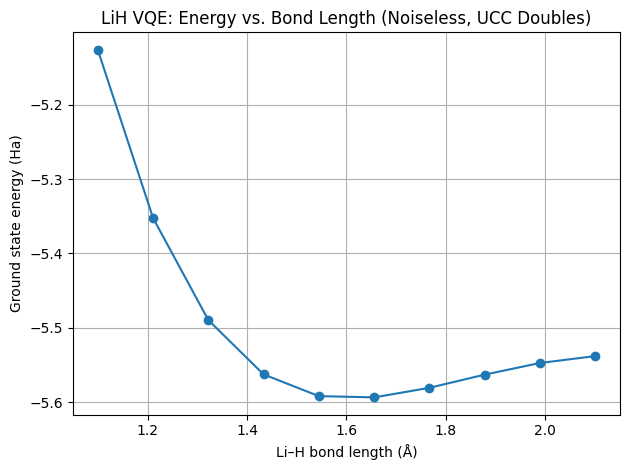

In [3]:
plt.plot(bond_lengths, energies, marker='o')
plt.xlabel("Li–H bond length (Å)")
plt.ylabel("Ground state energy (Ha)")
plt.title("LiH VQE: Energy vs. Bond Length (Noiseless, UCC Doubles)")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/LiH_Bond_Length_Scan.png", dpi=300)
plt.show()

In [4]:
energies = np.array(energies)    # Convert energies list to a NumPy array (for easy argmin)
min_index = np.argmin(energies)  # Find index of the minimum energy

# Retrieve optimal bond length and energy
optimal_r = bond_lengths[min_index]
optimal_energy = energies[min_index]

# Print result
print(f"\nOptimal bond length: {optimal_r:.2f} Å")
print(f"Minimum ground state energy: {optimal_energy:.8f} Ha")


Optimal bond length: 1.66 Å
Minimum ground state energy: -5.59345560 Ha
